<a id='top'></a>

# PCA and K-Means Clustering of Defenders

In [157]:
# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd
#import pandas_profiling as pp
import os
import re
import chardet
import random
from io import BytesIO
from pathlib import Path

# Reading Directories
import glob
import os

# Working with JSON
import json
from pandas.io.json import json_normalize

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Progress Bar
from tqdm import tqdm

# Display in Jupyter
from IPython.display import Image, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print('Setup Complete')

Setup Complete


In [158]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
%config InlineBackend.figure_format='retina'

### Defined Filepaths

In [159]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..')
data_dir = os.path.join(base_dir, 'data')
data_dir_sb = os.path.join(base_dir, 'data', 'sb')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')

### Notebook Settings

In [160]:
# Display all columns of displayed pandas DataFrames
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment=None

### Import Data

In [161]:
df_sb_agg_raw = pd.read_csv(os.path.join(data_dir, 'export', 'sb_wc2018_events_agg_all.csv'))

### Data Handling

In [162]:
df_sb_agg_raw.head()

,player,mins_total,team,position,position_name_grouped,outfielder_goalkeeper,age,dob,pob,cob,second_citizenship,current_club,current_club_country,height,foot,market_value_euros,market_value_pounds,joined,age_when_joining,years_since_joining,contract_expires,years_until_contract_expiry,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent,passes,completed_passes,open_play_passes,completed_open_play_passes,short_passes,completed_short_passes,medium_passes,completed_medium_passes,long_passes,completed_long_passes,final_third_pass,completed_final_third_pass,penalty_area_passes,completed_penalty_area_passes,under_pressure_passes,completed_under_pressure_passes,throughballs,completed_throughballs,switches,completed_switches,crosses,completed_crosses,penalty_area_crosses,completed_penalty_area_crosses,progressive_passes,completed_progressive_passes,total_pass_distance,progressive_pass_distance,carries,completed_carries,final_third_carries,completed_final_third_carries,progressive_Carries,completed_progressive_carries,carry_distance,progressive_carry_distance,xt,xt_faciliated,xgbuildup,xgchain,team.1,padj_defensive_acts,turnovers,aerial_challenges,aerial_win_%,true_tackle_win_%,padj_pressures,padj_completed_pressures,dribbles,padj_tackles_and_interceptions,tackle/dp_%,completed_expected_passes,passes_completed_above_expected,completed_open_play_passes.1,final_third_entries,progressive_moves,completed_passes_%,completed_open_play_passes_%,completed_long_passes_%,completed_under_pressure_passes_%,completed_progressive_passes_%,ppf,cpf,open_play_passes.1,completed_passes_and_carries,padj_defensive_acts_p90,turnovers_p90,aerial_challenges_p90,dribbles_p90,padj_presures_p90,padj_completed_pressures_p90,completed_passes_p90,completed_long_passes_p90,completed_final_thirdpasses_p90,completed_under_pressure_passes_p90,completed_progressive_passes_p90,total_pass_length_p90,carries_p90,carry_distance_p90,final_third_entries_p90,Progressive Passes_p90,Progressive Carries_p90,progressive_moves_p90,completed_open_play_passes_p90,completed_carries_p90,completed_progressive_carries_p90,completed_passes_and_carries_p90,turnovers_per_100_touches,percentile_primary_position_name,percentile_passes,percentile_completed_passes,percentile_open_play_Passes,percentile_completed_open_play_passes,percentile_short_passes,percentile_completed_short_passes,percentile_medium_passes,percentile_completed_medium_passes,percentile_long_passes,percentile_completed_long_passes,percentile_final_third_passes,percentile_completed_final_third_passes,percentile_penalty_area_passes,percentile_completed_penalty_area_passes,percentile_under_pressure_passes,percentile_completed_under_pressure_passes,percentile_throughballs,percentile_completed_throughballs,percentile_switches,percentile_completed_switches,percentile_crosses,percentile_completes_crosses,percentile_penalty_area_crosses,percentile_completed_penalty_area_crosses,percentile_progressive_passes,percentile_completed_progressive_passes,percentile_total_pass_length,percentile_pass_progressive_distance,percentile_carries,percentile_completed_carries,percentile_final_third_carries,percentile_completed_final_third_Carries,percentile_progressive_carries,percentile_completed_progressive_carries,percentile_carry_distance,percentile_progressive_carry_distance,percentile_xt,percentile_xt_facilitated,percentile_xgbuildup,percentile_xgchain,percentile_padj_defensive_acts,percentile_turnovers,percentile_aerial_challenges,percentile_aerial_win_%,percentile_true_tackle_win_%,percentile_padj_pressures,percentile_padj_completed_pressures,percentile_dribbles,percentile_padj_tackles_and_interceptions,percentile_tack/dp_%,percentile_,percentile_completed_open_play_passes.1,percentile_completed_expected_pass,percentile_pass_completed_above_expected,percentile_open_play_passes,percentile_final_third_entries,percentile_progressive_moves,percentile_completed_passes_%,percentile_completed_open_play_passes_%,percent

In [163]:
df_sb_agg_raw.shape

(600, 205)

In [164]:
# Displays all columns
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_sb_agg_raw.dtypes)

player                                                        object
mins_total                                                     int64
team                                                          object
position                                                      object
position_name_grouped                                         object
outfielder_goalkeeper                                         object
age                                                          float64
dob                                                           object
pob                                                           object
cob                                                           object
second_citizenship                                            object
current_club                                                  object
current_club_country                                          object
height                                                       float64
foot                              

### Data Engineering

#### Assign Raw DataFrame

In [165]:
df_sb_agg = df_sb_agg_raw

#### Filtering
Filter for Center Backs that have played at least 170 minutes.

In [166]:
df_sb_agg = df_sb_agg[ 
                      #(df_sb_agg['mins_total'] >= 170) &
                      ((df_sb_agg['position'] == 'Left Center Back') |
                       (df_sb_agg['position'] == 'Center Back') |
                       (df_sb_agg['position'] == 'Right Center Back')
                      ) 
                     ]

In [167]:
df_sb_agg.head()

,player,mins_total,team,position,position_name_grouped,outfielder_goalkeeper,age,dob,pob,cob,second_citizenship,current_club,current_club_country,height,foot,market_value_euros,market_value_pounds,joined,age_when_joining,years_since_joining,contract_expires,years_until_contract_expiry,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent,passes,completed_passes,open_play_passes,completed_open_play_passes,short_passes,completed_short_passes,medium_passes,completed_medium_passes,long_passes,completed_long_passes,final_third_pass,completed_final_third_pass,penalty_area_passes,completed_penalty_area_passes,under_pressure_passes,completed_under_pressure_passes,throughballs,completed_throughballs,switches,completed_switches,crosses,completed_crosses,penalty_area_crosses,completed_penalty_area_crosses,progressive_passes,completed_progressive_passes,total_pass_distance,progressive_pass_distance,carries,completed_carries,final_third_carries,completed_final_third_carries,progressive_Carries,completed_progressive_carries,carry_distance,progressive_carry_distance,xt,xt_faciliated,xgbuildup,xgchain,team.1,padj_defensive_acts,turnovers,aerial_challenges,aerial_win_%,true_tackle_win_%,padj_pressures,padj_completed_pressures,dribbles,padj_tackles_and_interceptions,tackle/dp_%,completed_expected_passes,passes_completed_above_expected,completed_open_play_passes.1,final_third_entries,progressive_moves,completed_passes_%,completed_open_play_passes_%,completed_long_passes_%,completed_under_pressure_passes_%,completed_progressive_passes_%,ppf,cpf,open_play_passes.1,completed_passes_and_carries,padj_defensive_acts_p90,turnovers_p90,aerial_challenges_p90,dribbles_p90,padj_presures_p90,padj_completed_pressures_p90,completed_passes_p90,completed_long_passes_p90,completed_final_thirdpasses_p90,completed_under_pressure_passes_p90,completed_progressive_passes_p90,total_pass_length_p90,carries_p90,carry_distance_p90,final_third_entries_p90,Progressive Passes_p90,Progressive Carries_p90,progressive_moves_p90,completed_open_play_passes_p90,completed_carries_p90,completed_progressive_carries_p90,completed_passes_and_carries_p90,turnovers_per_100_touches,percentile_primary_position_name,percentile_passes,percentile_completed_passes,percentile_open_play_Passes,percentile_completed_open_play_passes,percentile_short_passes,percentile_completed_short_passes,percentile_medium_passes,percentile_completed_medium_passes,percentile_long_passes,percentile_completed_long_passes,percentile_final_third_passes,percentile_completed_final_third_passes,percentile_penalty_area_passes,percentile_completed_penalty_area_passes,percentile_under_pressure_passes,percentile_completed_under_pressure_passes,percentile_throughballs,percentile_completed_throughballs,percentile_switches,percentile_completed_switches,percentile_crosses,percentile_completes_crosses,percentile_penalty_area_crosses,percentile_completed_penalty_area_crosses,percentile_progressive_passes,percentile_completed_progressive_passes,percentile_total_pass_length,percentile_pass_progressive_distance,percentile_carries,percentile_completed_carries,percentile_final_third_carries,percentile_completed_final_third_Carries,percentile_progressive_carries,percentile_completed_progressive_carries,percentile_carry_distance,percentile_progressive_carry_distance,percentile_xt,percentile_xt_facilitated,percentile_xgbuildup,percentile_xgchain,percentile_padj_defensive_acts,percentile_turnovers,percentile_aerial_challenges,percentile_aerial_win_%,percentile_true_tackle_win_%,percentile_padj_pressures,percentile_padj_completed_pressures,percentile_dribbles,percentile_padj_tackles_and_interceptions,percentile_tack/dp_%,percentile_,percentile_completed_open_play_passes.1,percentile_completed_expected_pass,percentile_pass_completed_above_expected,percentile_open_play_passes,percentile_final_third_entries,percentile_progressive_moves,percentile_completed_passes_%,percentile_completed_open_play_passes_%,percent

In [168]:
df_sb_agg.shape

(102, 205)

#### Select Numerical Columns

In [169]:
print(df_sb_agg.columns.tolist())

['player', 'mins_total', 'team', 'position', 'position_name_grouped', 'outfielder_goalkeeper', 'age', 'dob', 'pob', 'cob', 'second_citizenship', 'current_club', 'current_club_country', 'height', 'foot', 'market_value_euros', 'market_value_pounds', 'joined', 'age_when_joining', 'years_since_joining', 'contract_expires', 'years_until_contract_expiry', 'contract_option', 'on_loan_from', 'on_loan_from_country', 'loan_contract_expiry', 'player_agent', 'passes', 'completed_passes', 'open_play_passes', 'completed_open_play_passes', 'short_passes', 'completed_short_passes', 'medium_passes', 'completed_medium_passes', 'long_passes', 'completed_long_passes', 'final_third_pass', 'completed_final_third_pass', 'penalty_area_passes', 'completed_penalty_area_passes', 'under_pressure_passes', 'completed_under_pressure_passes', 'throughballs', 'completed_throughballs', 'switches', 'completed_switches', 'crosses', 'completed_crosses', 'penalty_area_crosses', 'completed_penalty_area_crosses', 'progressiv

In [170]:
# Define columns

## Str
cols_str = ['player',
            'team',
            'position',
            'position_name_grouped',
            'outfielder_goalkeeper',
            'dob',
            'pob',
            'cob',
            'second_citizenship',
            'current_club',
            'current_club_country',
            'foot',
            'joined',
            'contract_expires',
            'contract_option',
            'on_loan_from',
            'on_loan_from_country',
            'loan_contract_expiry',
            'player_agent',
            'team.1',
           ]

## Num
cols_num = ['mins_total',
            'age',
            'height',
            'market_value_euros',
            'market_value_pounds',
           #'age_when_joining',    # remove for the moment as Pique has a rogue value with a date
            'years_since_joining',
            'years_until_contract_expiry',
            'passes',
            'completed_passes',
            'open_play_passes',
            'completed_open_play_passes',
            'short_passes',
            'completed_short_passes',
            'medium_passes',
            'completed_medium_passes',
            'long_passes',
            'completed_long_passes',
            'final_third_pass',
            'completed_final_third_pass',
            'penalty_area_passes',
            'completed_penalty_area_passes',
            'under_pressure_passes',
            'completed_under_pressure_passes',
            'throughballs',
            'completed_throughballs',
            'switches',
            'completed_switches',
            'crosses',
            'completed_crosses',
            'penalty_area_crosses',
            'completed_penalty_area_crosses',
            'progressive_passes',
            'completed_progressive_passes',
            'total_pass_distance',
            'progressive_pass_distance',
            'carries',
            'completed_carries',
            'final_third_carries',
            'completed_final_third_carries',
            'progressive_Carries',
            'completed_progressive_carries',
            'carry_distance',
            'progressive_carry_distance',
            'xt',
            'xt_faciliated',
            'xgbuildup',
            'xgchain',
            'padj_defensive_acts',
            'turnovers',
            'aerial_challenges',
            'aerial_win_%',
            'true_tackle_win_%',
            'padj_pressures',
            'padj_completed_pressures',
            'dribbles',
            'padj_tackles_and_interceptions',
            'tackle/dp_%',
            'completed_expected_passes',
            'passes_completed_above_expected',
            'completed_open_play_passes.1',
            'final_third_entries',
            'progressive_moves',
            'completed_passes_%',
            'completed_open_play_passes_%',
            'completed_long_passes_%',
            'completed_under_pressure_passes_%',
            'completed_progressive_passes_%',
            'ppf',
            'cpf',
            'open_play_passes.1',
            'completed_passes_and_carries',
            'padj_defensive_acts_p90',
            'turnovers_p90',
            'aerial_challenges_p90',
            'dribbles_p90',
            'padj_presures_p90',
            'padj_completed_pressures_p90',
            'completed_passes_p90',
            'completed_long_passes_p90',
            'completed_final_thirdpasses_p90',
            'completed_under_pressure_passes_p90',
            'completed_progressive_passes_p90',
            'total_pass_length_p90',
            'carries_p90',
            'carry_distance_p90',
            'final_third_entries_p90',
            'Progressive Passes_p90',
            'Progressive Carries_p90',
            'progressive_moves_p90',
            'completed_open_play_passes_p90',
            'completed_carries_p90',
            'completed_progressive_carries_p90',
            'completed_passes_and_carries_p90',
            'turnovers_per_100_touches'
           ]

## Cols for Radar/Visual - here for reference
cols = ['mins_total',
        'passes',
        'completed_passes',
        'open_play_passes',
        'completed_open_play_passes',
        'short_passes',
        'completed_short_passes',
        'medium_passes',
        'completed_medium_passes',
        'long_passes',
        'completed_long_passes',
        'final_third_pass',
        'completed_final_third_pass',
        'penalty_area_passes',
        'completed_penalty_area_passes',
        'under_pressure_passes',
        'completed_under_pressure_passes',
        'throughballs',
        'completed_throughballs',
        'switches',
        'completed_switches',
        'crosses',
        'completed_crosses',
        'penalty_area_crosses',
        'completed_penalty_area_crosses',
        'progressive_passes',
        'completed_progressive_passes',
        'total_pass_distance',
        'progressive_pass_distance',
        'carries',
        'completed_carries',
        'final_third_carries',
        'completed_final_third_carries',
        'progressive_Carries',
        'completed_progressive_carries',
        'carry_distance',
        'progressive_carry_distance',
        'xt',
        'xt_faciliated',
        'xgbuildup',
        'xgchain',
        'padj_defensive_acts',
        'turnovers',
        'aerial_challenges',
        'aerial_win_%',
        'true_tackle_win_%',
        'padj_pressures',
        'padj_completed_pressures',
        'dribbles',
        'padj_tackles_and_interceptions',
        'tackle/dp_%',
        'completed_expected_passes',
        'passes_completed_above_expected',
        'completed_open_play_passes.1',
        'final_third_entries',
        'progressive_moves',
        'completed_passes_%',
        'completed_open_play_passes_%',
        'completed_long_passes_%',
        'completed_under_pressure_passes_%',
        'completed_progressive_passes_%',
        'ppf',
        'cpf',
        'open_play_passes.1',
        'completed_passes_and_carries',
        'padj_defensive_acts_p90',
        'turnovers_p90',
        'aerial_challenges_p90',
        'dribbles_p90',
        'padj_presures_p90',
        'padj_completed_pressures_p90',
        'completed_passes_p90',
        'completed_long_passes_p90',
        'completed_final_thirdpasses_p90',
        'completed_under_pressure_passes_p90',
        'completed_progressive_passes_p90',
        'total_pass_length_p90',
        'carries_p90',
        'carry_distance_p90',
        'final_third_entries_p90',
        'Progressive Passes_p90',
        'Progressive Carries_p90',
        'progressive_moves_p90',
        'completed_open_play_passes_p90',
        'completed_carries_p90',
        'completed_progressive_carries_p90',
        'completed_passes_and_carries_p90',
        'turnovers_per_100_touches'
       ]

## All
cols_all = cols_str + cols_num

In [171]:
# Create DataFrame of string values

## Select columns of interest
df_sb_agg_str_select = df_sb_agg[cols_str]

## Drop duplicate column (duplicate 'team', temporary solution, needs to be moved up)
df_sb_agg_str_select = df_sb_agg_str_select.loc[:, ~df_sb_agg_str_select.columns.duplicated()]

## Display DataFrame
df_sb_agg_str_select.head()

,player,team,position,position_name_grouped,outfielder_goalkeeper,dob,pob,cob,second_citizenship,current_club,current_club_country,foot,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent,team.1
13,Ahmed Hegazi,Egypt,Left Center Back,Defender,Outfielder,25/01/1991,Ismailia,Egypt,NaN,Al-Ittihad Jeddah,Saudi Arabia,Right,01/07/2021,30/06/2023,NaN,NaN,NaN,NaN,CAA Base Ltd,Egypt
18,Alberto Junior Rodríguez Valdelomar,Peru,Left Center Back,Defender,Outfielder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Peru
30,Ali Albulayhi,Saudi Arabia,Left Center Back,Defender,Outfielder,21/11/1989,Diriyah,Saudi Arabia,NaN,Al-Hilal Riyadh,Saudi Arabia,Left,01/07/2017,30/06/2023,NaN,NaN,NaN,NaN,NaN,Saudi Arabia
31,Ali Gabr,Egypt,Right Center Back,Defender,Outfielder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Egypt
38,Anderson Santamaría Bardales,Peru,Left Center Back,Defender,Outfielder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Peru


In [172]:
df_sb_agg_str_select.shape

(102, 20)

In [173]:
# Create DataFrame of numerical values

## Select columns of interest
df_sb_agg_num_select = df_sb_agg[cols]

## Drop duplicate column (duplicate 'team', temporary solution, needs to be moved up)
df_sb_agg_num_select = df_sb_agg_num_select.loc[:, ~df_sb_agg_num_select.columns.duplicated()]

## Display DataFrame
df_sb_agg_num_select.head()

,mins_total,passes,completed_passes,open_play_passes,completed_open_play_passes,short_passes,completed_short_passes,medium_passes,completed_medium_passes,long_passes,completed_long_passes,final_third_pass,completed_final_third_pass,penalty_area_passes,completed_penalty_area_passes,under_pressure_passes,completed_under_pressure_passes,throughballs,completed_throughballs,switches,completed_switches,crosses,completed_crosses,penalty_area_crosses,completed_penalty_area_crosses,progressive_passes,completed_progressive_passes,total_pass_distance,progressive_pass_distance,carries,completed_carries,final_third_carries,completed_final_third_carries,progressive_Carries,completed_progressive_carries,carry_distance,progressive_carry_distance,xt,xt_faciliated,xgbuildup,xgchain,padj_defensive_acts,turnovers,aerial_challenges,aerial_win_%,true_tackle_win_%,padj_pressures,padj_completed_pressures,dribbles,padj_tackles_and_interceptions,tackle/dp_%,completed_expected_passes,passes_completed_above_expected,completed_open_play_passes.1,final_third_entries,progressive_moves,completed_passes_%,completed_open_play_passes_%,completed_long_passes_%,completed_under_pressure_passes_%,completed_progressive_passes_%,ppf,cpf,open_play_passes.1,completed_passes_and_carries,padj_defensive_acts_p90,turnovers_p90,aerial_challenges_p90,dribbles_p90,padj_presures_p90,padj_completed_pressures_p90,completed_passes_p90,completed_long_passes_p90,completed_final_thirdpasses_p90,completed_under_pressure_passes_p90,completed_progressive_passes_p90,total_pass_length_p90,carries_p90,carry_distance_p90,final_third_entries_p90,Progressive Passes_p90,Progressive Carries_p90,progressive_moves_p90,completed_open_play_passes_p90,completed_carries_p90,completed_progressive_carries_p90,completed_passes_and_carries_p90,turnovers_per_100_touches
13,277,125,9.817670,101,83,20,14,58,45,45,10.397112,11,1.299639,2,0,23,4.873646,0,0,1,1,0,0,0,0,9.097473,3.574007,1121.403486,1538.430921,29.891697,29.891697,1,1,0.32491,0.32491,196.933056,313.944172,0.106962,0.070874,0.110213,0.110213,9.854374,0.649819,1.949458,33.333333,50.000000,4.455990,0.688326,0.000000,6.713979,66.666667,95.04264,0.978508,26.967509,1.624549,3.898917,74.400000,82.178218,71.111111,65.217391,39.285714,0.445737,0.517960,NaN,60.108303,9.854374,0.649819,1.949458,0.000000,4.455990,0.688326,9.817670,10.397112,1.299639,4.873646,3.574007,1121.403486,29.891697,196.933056,1.624549,9.097473,0.32491,3.898917,26.967509,29.891697,0.32491,60.108303,2.173913
18,134,56,22.104032,44,39,14,13,23,22,13,7.388060,6,2.686567,1,0,5,2.686567,0,0,3,3,0,0,0,0,3.358209,1.343284,801.749330,397.686271,24.179104,24.179104,1,1,0.00000,0.00000,152.364618,129.213255,0.104927,0.090112,0.049507,0.049507,11.593611,1.343284,3.358209,40.000000,0.000000,8.767995,3.211765,0.671642,2.199336,0.000000,47.34055,1.035053,26.194030,3.358209,1.343284,87.500000,88.636364,84.615385,80.000000,40.000000,0.333150,0.569588,NaN,57.089552,11.593611,1.343284,3.358209,0.671642,8.767995,3.211765,22.104032,7.388060,2.686567,2.686567,1.343284,801.749330,24.179104,152.364618,3.358209,3.358209,0.00000,1.343284,26.194030,24.179104,0.00000,57.089552,5.405405
30,93,42,33.714880,37,32,18,17,13,10,11,8.709677,4,3.870968,0,0,9,5.806452,0,0,2,2,0,0,0,0,3.870968,1.935484,864.092741,370.935502,30.967742,30.967742,0,0,0.00000,0.00000,204.493313,122.580456,0.112546,0.096124,0.011709,0.011709,13.341891,0.000000,0.000000,0.000000,50.000000,5.559121,1.111824,0.000000,4.595540,50.000000,35.22777,0.993534,30.967742,3.870968,1.935484,85.714286,86.486486,81.818182,66.666667,50.000000,0.415430,0.580098,NaN,65.806452,13.341891,0.000000,0.000000,0.000000,5.559121,1.111824,33.714880,8.709677,3.870968,5.806452,1.935484,864.092741,30.967742,204.493313,3.870968,3.870968,0.00000,1.935484,30.967742,30.967742,0.00000,65.806452,0.000000
31,273,82,6.738317,72,58,16,15,38,32,24,4.945055,4,0.000000,2,1,16,2.967033,0,0,3,2,1,1,1,1,4.615385,1.318681,695.978626,939.866036,17.142857,17.142857,0,0,0.00000,0.00000,71

In [174]:
df_sb_agg_num_select.shape

(102, 88)

#### Replace nulls
Replace null values with the mean - method elected to go with.

In [175]:
df_sb_agg_num_select = df_sb_agg_num_select.fillna(df_sb_agg_num_select.mean())
#df_sb_agg_num_select.fillna(0, inplace=True)   # Alt method

#### Standardise Data
Standardise the data to have a mean of ~0 and a variance of 1.

In [176]:
# Standardise Data

## Method 1
#X_std = StandardScaler().fit_transform(df_sb_agg_num_select)

## Method 2
X = df_sb_agg_num_select.values

scaler = preprocessing.MinMaxScaler()

X_std = scaler.fit_transform(X)

X_norm = pd.DataFrame(X_std)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


### ML
Following the following article: https://medium.com/@dmitriy.kavyazin/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2

#### PCA

##### Replace Infinity Values
Replace infinity values with high finite values and the nan values with numbers: https://stackoverflow.com/questions/31323499/sklearn-error-valueerror-input-contains-nan-infinity-or-a-value-too-large-for

In [177]:
X_std = np.nan_to_num(X_std)

##### Create a PCA Instance

In [178]:
# Create a PCA instance: pca
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(X_std)

##### Plot the explained variances

([<matplotlib.axis.XTick at 0x11db94350>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

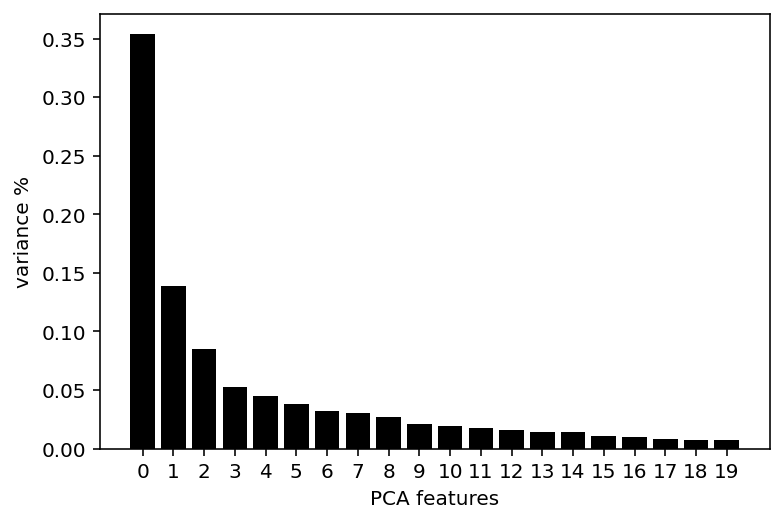

In [179]:
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

The figure shows that the first component explain the majority of the variance in our data. For this visualization use case, we will quickly plot just the first two. We do this to notice if there are any clear clusters.

In [183]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

##### Visualise PCA for Clusters

Text(0, 0.5, 'PCA 2')

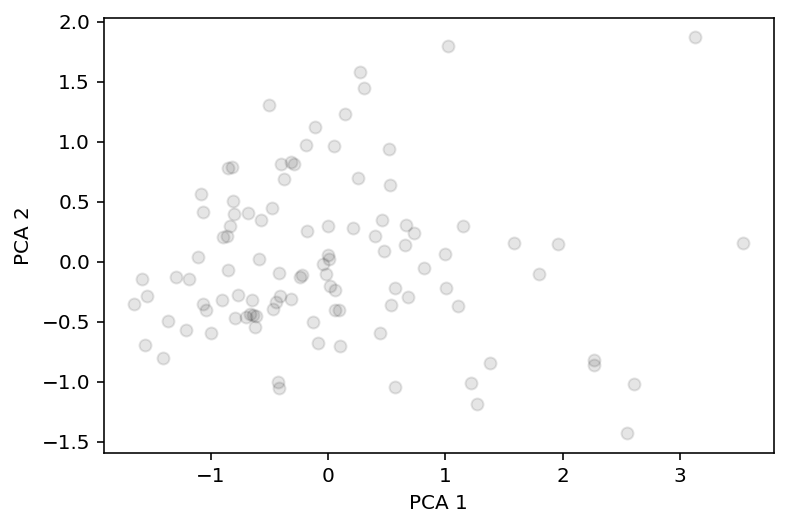

In [181]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

#### K-Means

##### Determine the number of clusters

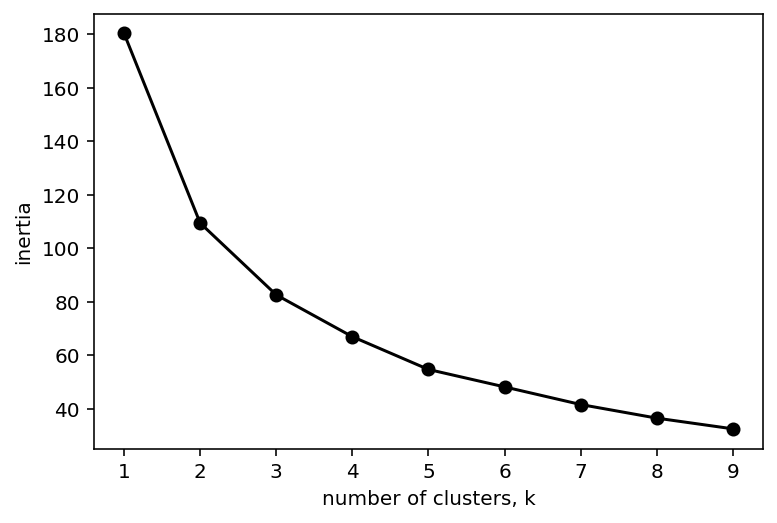

In [182]:
ks = range(1, 10)

inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

As it is evident that there is no particular elbow for this dataset, so in this article I will do it using 5 clusters.

In [184]:
# specify the number of clusters
kmeans = KMeans(n_clusters=5)

# fit the input data
kmeans = kmeans.fit(PCA_components)

# get the cluster labels
labels = kmeans.predict(PCA_components)

# centroid values
centroid = kmeans.cluster_centers_

# cluster values
clusters = kmeans.labels_.tolist()

In [187]:
PCA_components['cluster'] = clusters
#PCA_components['name'] = names
PCA_components.columns = ['x', 'y', 'cluster']
PCA_components.head()

ValueError: Length mismatch: Expected axis has 21 elements, new values have 3 elements